In [1]:
import os
import sys
sys.path.append('/home/royhirsch/conformal/')

from ml_collections import config_dict
import logging
import pandas as pd
import pickle
import torch
import torch.nn as nn
import numpy as np

from experiment import predict_and_report_mets
from conformal import get_conformal_module, get_percentile, clip_scores, calibrate_residual
from conformal_baselines import calc_baseline_mets
from data import get_dataloaders
from model import NN
from trainer import Trainer, get_optimizer, get_scheduler
from config import get_config_by_name
import utils as utils


In [2]:
dataset_name = 'organamnist' # 'tissuemnist'
config = get_config_by_name(dataset_name)
utils.seed_everything(config.seed)
utils.create_logger(config.exp_dir, False)

logging.info('Config:')
for k, v in config.items():
    logging.info(f'{k}: {v}')
logging.info('')

conformal_module = get_conformal_module(config.conformal_module_name)
dls, t = get_dataloaders(config, conformal_module)
train_dl = dls['train']
valid_dl = dls['valid']
test_dl = dls['test']
baseline_mets = calc_baseline_mets(train_dl, valid_dl, alpha=config.alpha, k_raps=config.k_raps)

# if use clipping, need to re-calc the scores for the datasets
if config.use_score_clipping:
    qhat = get_percentile(train_dl.dataset.scores, config.alpha)

    conformal_module.set_score_clipping(qhat)
    train_dl.dataset.scores = clip_scores(
        train_dl.dataset.scores, qhat)
    valid_dl.dataset.scores = clip_scores(
        valid_dl.dataset.scores, qhat)
    test_dl.dataset.scores = clip_scores(
        test_dl.dataset.scores, qhat)

    sets = conformal_module.get_sets(
        test_dl.dataset.scores.numpy(),
        test_dl.dataset.cls_probs.numpy())
    mets = conformal_module.get_conformal_mets(
        sets, test_dl.dataset.cls_labels.numpy())
    utils.log('Baseline mets (after clipping)', mets)


model = NN(input_dim=config.input_dim,
            hidden_dim=config.hidden_dim,
            norm=config.norm,
            drop_rate=config.drop_rate,
            criteria_name=config.criteria_name)
model = model.to(config.device)
logging.info(model)

optimizer = get_optimizer(model, config)
scheduler = get_scheduler(optimizer, config)

if config.criteria_name == 'mse':
    criteria = nn.MSELoss()
elif config.criteria_name == 'bce':
    criteria = nn.BCELoss()
else:
    raise ValueError(f'Invalid loss name {config.criteria_name}')

trainer = Trainer(criteria=criteria,
                    metric_logger=utils.RegressionMetricLogger,
                    config=config)

trainer.fit(model=model,
            train_loader=train_dl,
            test_loader=valid_dl,
            optimizer=optimizer,
            scheduler=scheduler,
            valid_loader=valid_dl)

# predict regression results for the trained model
conformal_module.score_clip_value = 0.99
train_predict_out, train_mets = predict_and_report_mets(
    conformal_module, trainer, model, train_dl, fold_name='Train')

val_predict_out, val_mets = predict_and_report_mets(
    conformal_module, trainer, model, valid_dl, fold_name='Valid')

test_predict_out, test_mets = predict_and_report_mets(
    conformal_module, trainer, model, test_dl, fold_name='Test')

# calibrate the predicted scores
calibrated_test_pred_scores, qhat_below, qhat_above = calibrate_residual(
    train_predict_out,
    test_predict_out, 
    config.alpha,
    config.method_name)

conformal_module = get_conformal_module(config.conformal_module_name)
sets = conformal_module.get_sets(calibrated_test_pred_scores,
                                    test_predict_out['cls_probs'])
calibrated_test_mets = conformal_module.get_conformal_mets(
    sets, test_predict_out['cls_labels'])
utils.log('Calibrated test mets', calibrated_test_mets)

baseline_mets['cp_net'] = test_mets
baseline_mets['cp_net_post'] = calibrated_test_mets
df_mets = pd.DataFrame(baseline_mets).T
logging.info(df_mets)
if config.dump_log:
    df_mets.to_csv(os.path.join(config.exp_dir, 'results.csv'))

calibrated_test_mets['qhat_below'] = qhat_below
calibrated_test_mets['qhat_above'] = qhat_above


INFO - 11/04/23 13:50:49 - 0:00:00 - Created main log at tmp/net_launcher_log.log
INFO - 11/04/23 13:50:49 - 0:00:00 - Config:
INFO - 11/04/23 13:50:49 - 0:00:00 - alpha: 0.1
INFO - 11/04/23 13:50:49 - 0:00:00 - batch_size: 128
INFO - 11/04/23 13:50:49 - 0:00:00 - comments: 
INFO - 11/04/23 13:50:49 - 0:00:00 - conformal_module_name: aps
INFO - 11/04/23 13:50:49 - 0:00:00 - criteria_name: mse
INFO - 11/04/23 13:50:49 - 0:00:00 - dataset_name: organamnist
INFO - 11/04/23 13:50:49 - 0:00:00 - device: cuda:0
INFO - 11/04/23 13:50:49 - 0:00:00 - drop_rate: 0.0
INFO - 11/04/23 13:50:49 - 0:00:00 - dump_log: False
INFO - 11/04/23 13:50:49 - 0:00:00 - exp_dir: tmp
INFO - 11/04/23 13:50:49 - 0:00:00 - file_name: /home/royhirsch/conformal/data/embeds_n_logits/aug/medmnist/organmnist_test.pickle
INFO - 11/04/23 13:50:49 - 0:00:00 - gpu_num: 0
INFO - 11/04/23 13:50:49 - 0:00:00 - hidden_dim: 32
INFO - 11/04/23 13:50:49 - 0:00:00 - input_dim: 2048
INFO - 11/04/23 13:50:49 - 0:00:00 - k_raps: 5
INF

In [3]:
import os, sys, inspect
sys.path.insert(1, os.path.join(sys.path[0], './conformal_classification/'))

import torch
import torch.nn as nn
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision

import medmnist
from medmnist import INFO, Evaluator
import PIL

device = torch.device('cuda:2')
BATCH_SIZE = 128
download = False

info = INFO[dataset_name]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

data_transform = transforms.Compose(
    [transforms.Resize((224, 224), interpolation=PIL.Image.NEAREST), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])])

val_dataset = DataClass(split='val', transform=data_transform, download=download, as_rgb=True)
test_dataset = DataClass(split='test', transform=data_transform, download=download, as_rgb=True)

val_loader = data.DataLoader(dataset=val_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)


In [4]:
from scipy.special import softmax
from extract import get_embeds_logits

num_classes = len(np.unique(val_dataset.labels))
resnet_model = torchvision.models.resnet50(pretrained=False, num_classes=num_classes)

resnet_model.load_state_dict(torch.load(f'/home/royhirsch/conformal/notebooks/medmnist/{dataset_name}/resnet50_224_1.pth')['net'])
resnet_model = resnet_model.to(device)
resnet_model = resnet_model.eval()
all_embeds, all_preds, all_labels = get_embeds_logits(resnet_model, test_loader, device)


all_preds = softmax(all_preds / t, 1)

/home/royhirsch/miniconda3/envs/conf/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/royhirsch/miniconda3/envs/conf/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


100%|██████████| 70/70 [00:29<00:00,  2.40it/s]


In [5]:
from data import get_dataloader
n = 2048
embeds = all_embeds[:n, :]
preds = all_preds[:n, :]
labels = all_labels[:n, 0]

dl = get_dataloader(embeds, preds, labels, labels)
model.eval()
with torch.no_grad():
    inp = torch.tensor(embeds).to(config.device)
    pred_scores = model(inp).detach().cpu().numpy().flatten()

valid_outputs = {'cls_probs': preds,
                 'pred_scores': pred_scores}
correct_pred_scores, qhat_below, qhat_above = calibrate_residual(
    train_predict_out,
    valid_outputs, 
    config.alpha,
    config.method_name)
conformal_module = get_conformal_module(config.conformal_module_name)
sets = conformal_module.get_sets(correct_pred_scores, preds)

set_lens = []
hits = []
hits_per_label = {}
for s, l in zip(sets, labels):
    set_lens.append(len(s))
    if l not in hits_per_label:
        hits_per_label[l] = []
    if l in s:
        hits.append(1)
        hits_per_label[l].append(1)
    else:
        hits.append(0)
        hits_per_label[l].append(0)

df = pd.DataFrame(columns=['label', 'my_hit', 'my_size', 'my_set'])
df['label'] = labels
df['my_hit'] = hits
df['my_size'] = set_lens
df['my_set'] = sets

INFO - 11/04/23 13:52:23 - 0:01:34 - Residuals correction is [0.140, 0.080], clip 28.71% of the samples


In [6]:
from conformal_baselines import calc_baseline_details
baseline_details = calc_baseline_details(train_dl, dl, alpha=config.alpha, k_raps=config.k_raps)
for k, v in baseline_details.items():
    df[k] = v[:n]

In [7]:
df.head()

,label,my_hit,my_size,my_set,naive_hits,naive_size,naive_set,aps_hits,aps_size,aps_set,aps_rand_hits,aps_rand_size,aps_rand_set,raps_hits,raps_size,raps_set,raps_rand_hits,raps_rand_size,raps_rand_set
0,4,0,3,"(6, 9, 10)",0,3,"(6, 9, 10)",1,7,"(0, 1, 3, 4, 6, 9, 10)",0,3,"(6, 9, 10)",0,3,"(6, 9, 10)",0,2,"(6, 9)"
1,0,1,1,"(0,)",1,1,"(0,)",1,2,"(0, 10)",1,1,"(0,)",1,1,"(0,)",1,1,"(0,)"
2,8,1,1,"(8,)",1,1,"(8,)",0,0,(),1,1,"(8,)",1,1,"(8,)",1,1,"(8,)"
3,6,1,4,"(5, 6, 4, 8)",1,5,"(5, 6, 4, 8, 3)",1,8,"(0, 2, 3, 4, 5, 6, 8, 10)",1,5,"(3, 4, 5, 6, 8)",1,5,"(3, 4, 5, 6, 8)",1,4,"(4, 5, 6, 8)"
4,5,1,3,"(4, 5, 10)",1,3,"(4, 5, 10)",1,6,"(0, 4, 5, 6, 9, 10)",1,3,"(4, 5, 10)",1,3,"(4, 5, 10)",1,3,"(4, 5, 10)"


In [8]:
def comp(target_name):
    return np.asarray((df['my_size'] < df[target_name]).tolist())

def multi_comp(target_names=['naive', 'aps', 'aps_rand', 'raps', 'raps_rand']):
    r = np.asarray([True] * n)
    for target_name in target_names:
        r = r & comp(target_name + '_size')
    return r

print('Indexes with improved results')
# np.where(multi_comp())[0]


Indexes with improved results


In [9]:
m = {int(k): v for k, v in test_dataset.info['label'].items()}

def tolables(l, m=m):
    r = [m[ll] for ll in l]
    return str(r)

def get_sets_string(index, target_names=['naive', 'aps', 'aps_rand', 'raps', 'raps_rand']):
    r = df.iloc[index].to_dict()
    s = 'True label: ' + m[r['label']] + '\n'
    s += 'CPSN: ' + tolables(r['my_set'])
    for t in target_names:
        s += '\n' + t + ': ' + tolables(r[f'{t}_set'])
    return s

def get_sets(index, target_names=['naive', 'aps', 'aps_rand', 'raps', 'raps_rand']):
    r = df.iloc[index].to_dict()
    s = {}
    s['True label'] = [m[r['label']]]
    s['CPSN'] = [m[ll] for ll in r['my_set']]
    for t in target_names:
        s[t] = [m[ll] for ll in r[f'{t}_set']]
    return s



In [10]:
if dataset_name == 'tissuemnist':
     shortcuts = {
          'Collecting Duct, Connecting Tubule': 'C',
          'Distal Convoluted Tubule': 'DCT',
          'Glomerular endothelial cells': 'GEC',
          'Interstitial endothelial cells': 'IEC',
          'Leukocytes': 'L',
          'Podocytes': 'P',
          'Proximal Tubule Segments': 'PTS',
          'Thick Ascending Limb': 'TAL'
          }
else:
     shortcuts = {'bladder': 'B',
                  'femur-left': 'FL',
                  'femur-right': 'FR',
                  'heart': 'H',
                  'kidney-left': 'KL',
                  'kidney-right': 'KR',
                  'liver': 'L',
                  'lung-left': 'LL',
                  'lung-right': 'LR',
                  'pancreas': 'P',
                  'spleen': 'S'}
     
def replace_phrases(sentence, replacement_map=shortcuts):
    # Split the sentence into words
    words = sentence.split()
    # Replace phrases in the sentence based on the replacement map
    modified_words = [replacement_map[word] if word in replacement_map else word for word in words]
    # Join the modified words back into a sentence
    modified_sentence = ' '.join(modified_words)
    return modified_sentence


True label : ['KR']
CPSN : ['KR', 'S', 'KL']
naive : ['KR', 'S', 'KL', 'B']
aps : ['B', 'FR', 'KL', 'KR', 'LR', 'P', 'S']
aps_rand : ['B', 'KL', 'KR', 'S']
raps : ['B', 'KL', 'KR', 'S']
raps_rand : ['B', 'KL', 'KR', 'S']


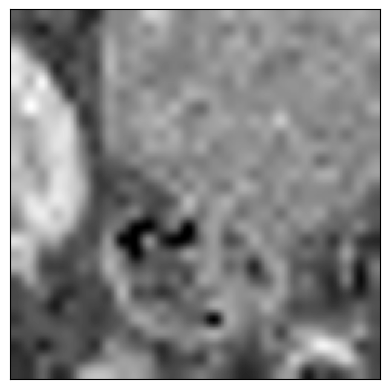

In [12]:
import matplotlib.pyplot as plt
from PIL import Image

index = 73
img, target = test_dataset.imgs[index], test_dataset.labels[index].astype(int)
img = Image.fromarray(img).resize((128, 128))

plt.imshow(img, cmap='gray')
plt.grid(False); plt.xticks([]); plt.yticks([])
# plt.title(get_sets_string(index))
for k, v in get_sets(index).items():
    print('{} : {}'.format(k, [shortcuts[vv] for vv in v]))